<a href="https://colab.research.google.com/github/salilp42/salilp42.github.io/blob/master/HTNretinaResNetv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
IMG_SIZE = 224
BATCH_SIZE = 32
NO_EPOCHS = 50
NUM_CLASSES = 2
DATA_FOLDER = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images"
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import cv2 as cv
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
import tensorflow_addons as tfa
import tensorflow as tf
%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import pandas as pd

df = pd.read_excel (r'/datasets_611716_1094714_ODIR-5K_data.xlsx')
print (df)

        ID  Patient Age Patient Sex    Left-Fundus  ...  A  H  M  O
0        0           69      Female     0_left.jpg  ...  0  0  0  0
1        1           57        Male     1_left.jpg  ...  0  0  0  0
2        2           42        Male     2_left.jpg  ...  0  0  0  1
3        3           66        Male     3_left.jpg  ...  0  0  0  1
4        4           53        Male     4_left.jpg  ...  0  0  0  1
...    ...          ...         ...            ...  ... .. .. .. ..
3495  4686           63        Male  4686_left.jpg  ...  0  0  0  0
3496  4688           42        Male  4688_left.jpg  ...  0  0  0  0
3497  4689           54        Male  4689_left.jpg  ...  0  0  0  0
3498  4690           57        Male  4690_left.jpg  ...  0  0  0  0
3499  4784           58        Male  4784_left.jpg  ...  1  1  0  0

[3500 rows x 15 columns]


In [7]:
df.columns = ["id", 'age', "sex", "left_fundus", "right_fundus", "left_diagnosys", "right_diagnosys", "normal",
                  "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other"]

In [8]:
print(df.loc[(df.hypertension==1)].shape)
print(df.loc[df.hypertension==0].shape)

(103, 15)
(3397, 15)


In [9]:
df.loc[(df.hypertension==1)]['left_diagnosys'].value_counts()

hypertensive retinopathy                                           53
moderate non proliferative retinopathy，hypertensive retinopathy    16
mild nonproliferative retinopathy，hypertensive retinopathy          7
severe nonproliferative retinopathy，hypertensive retinopathy        5
hypertensive retinopathy，mild nonproliferative retinopathy          2
proliferative diabetic retinopathy，hypertensive retinopathy         2
mild nonproliferative retinopathy                                   2
glaucoma，hypertensive retinopathy                                   2
old chorioretinopathy                                               1
dry age-related macular degeneration，hypertensive retinopathy       1
hypertensive retinopathy，suspected diabetic retinopathy             1
hypertensive retinopathy，optic nerve atrophy                        1
hypertensive retinopathy,diabetic retinopathy                       1
hypertensive retinopathy，moderate non proliferative retinopathy     1
hypertensive retinop

In [10]:
df.loc[(df.hypertension==1)]['right_diagnosys'].value_counts()

hypertensive retinopathy                                                   51
moderate non proliferative retinopathy，hypertensive retinopathy            15
proliferative diabetic retinopathy，hypertensive retinopathy                 4
glaucoma，hypertensive retinopathy                                           4
severe nonproliferative retinopathy，hypertensive retinopathy                4
hypertensive retinopathy，mild nonproliferative retinopathy                  3
mild nonproliferative retinopathy                                           3
mild nonproliferative retinopathy，hypertensive retinopathy                  2
hypertensive retinopathy，macular epiretinal membrane                        2
hypertensive retinopathy，cataract                                           2
hypertensive retinopathy，moderate non proliferative retinopathy             1
dry age-related macular degeneration                                        1
dry age-related macular degeneration，hypertensive retinopathy   

In [13]:
def has_hypertension_mentioned(text):
    if 'hypertensive' in text:
        return 1
    else:
        return 0


In [14]:
df['le_hypertension'] = df['left_diagnosys'].apply(lambda x: has_hypertension_mentioned(x))
df['re_hypertension'] = df['right_diagnosys'].apply(lambda x: has_hypertension_mentioned(x))

hypertension_le_list = df.loc[(df.hypertension==1) & (df.le_hypertension==1)]['left_fundus'].values
hypertension_re_list = df.loc[(df.hypertension==1) & (df.re_hypertension==1)]['right_fundus'].values
print(len(hypertension_le_list), len(hypertension_re_list))
non_hypertension_le_list = df.loc[(df.hypertension==0) & (df.left_diagnosys=="normal fundus")]['left_fundus'].sample(150, random_state=314).values
non_hypertension_re_list = df.loc[(df.hypertension==0) & (df.right_diagnosys=="normal fundus")]['right_fundus'].sample(150, random_state=314).values
print(len(non_hypertension_le_list), len(non_hypertension_re_list))

96 97
150 150


In [16]:
hypertension_list = np.concatenate((hypertension_le_list, hypertension_re_list), axis = 0)
non_hypertension_list = np.concatenate((non_hypertension_le_list, non_hypertension_re_list), axis = 0)
print(len(non_hypertension_list), len(hypertension_list))


NameError: ignored

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wEeZdwXnFf9WnoBsABYcxYeL2EfZP5oxYlaXDPB_nyirKqP2b_AxQ0
Mounted at /content/gdrive


In [31]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [32]:
!pip install -q keras
import keras

In [33]:
train_path = '/content/gdrive/My Drive/Kaggle/ODIR-5K/TrainI'
test_oath = '/content/gdrive/My Drive/Kaggle/ODIR-5K/TestI'

In [21]:
train_path

'/content/gdrive/My Drive/Kaggle/ODIR-5K/TrainI'

In [22]:
print(len(os.listdir(train_path)))

7000


In [34]:
def label_image(label):
    if label == 1:
        return [1,0]
    elif label == 0: 
        return [0,1]

def process_data(data_image_list, train_path, is_hypertension):
    df = []
    for img in tqdm(data_image_list):
        path = os.path.join(train_path,img)
        label = label_image(is_hypertension)
        img = cv.imread(path,cv.IMREAD_COLOR)
        img = cv.resize(img, (IMG_SIZE,IMG_SIZE))
        df.append([np.array(img),np.array(label)])
    shuffle(df)
    return df

In [28]:
hypertension_list = np.concatenate((hypertension_le_list, hypertension_re_list), axis = 0)
non_hypertension_list = np.concatenate((non_hypertension_le_list, non_hypertension_re_list), axis = 0)
print(len(non_hypertension_list), len(hypertension_list))


300 193


In [37]:
hypertension_df = process_data(hypertension_list, train_path, 1)


100%|██████████| 193/193 [01:48<00:00,  1.78it/s]


In [38]:
hypertension_no_df = process_data(non_hypertension_list, train_path, 0)

100%|██████████| 300/300 [02:47<00:00,  1.79it/s]


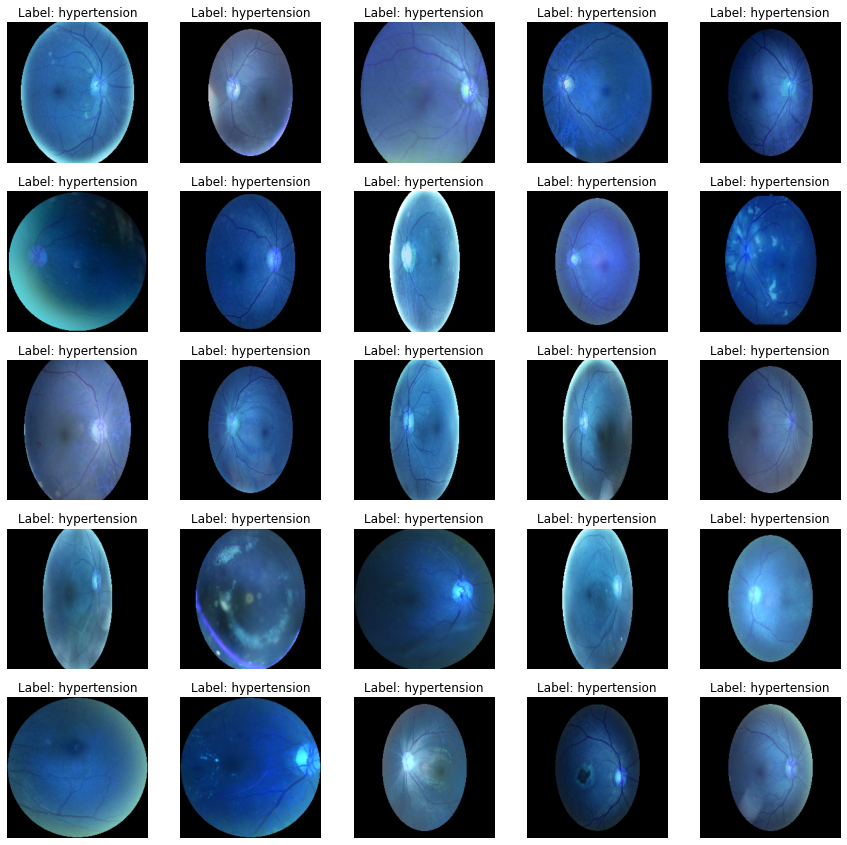

In [39]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 0: 
            str_label='hypertension'
        elif label == 1: 
            str_label='No A<D'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(hypertension_df)

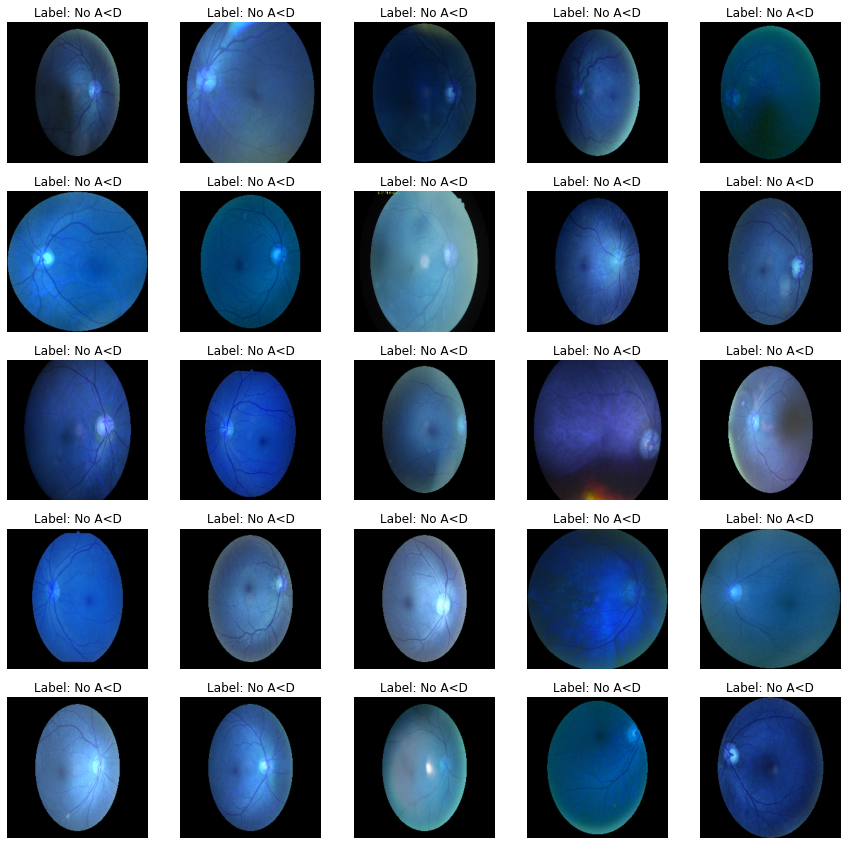

In [40]:
show_images(hypertension_no_df)


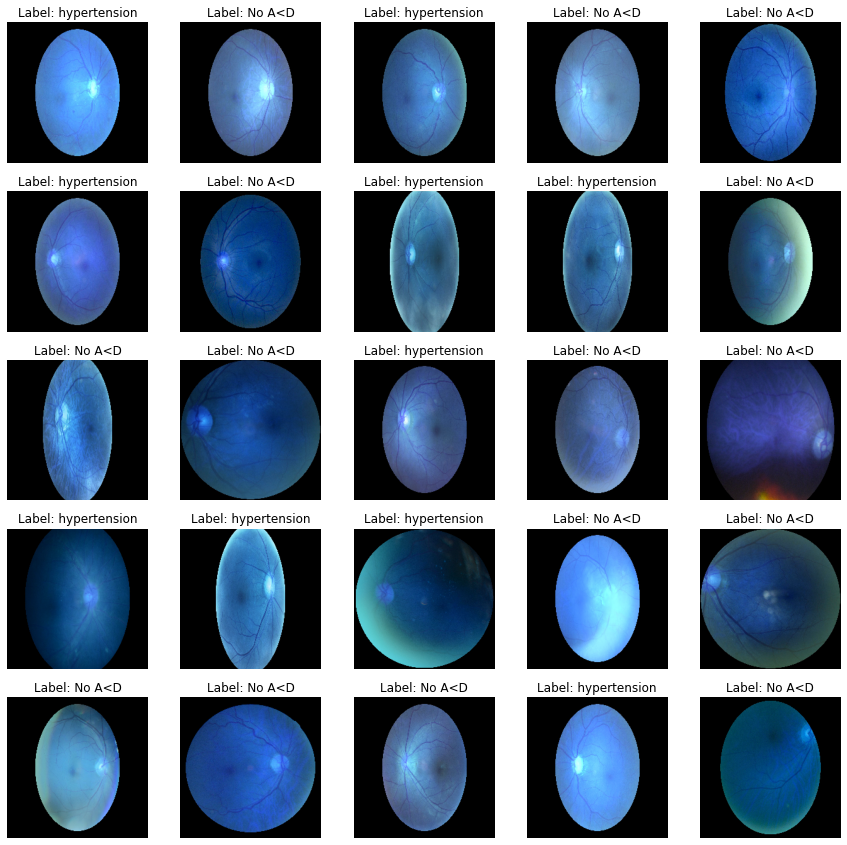

In [41]:
train = hypertension_df + hypertension_no_df
shuffle(train)
show_images(train)


In [42]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])


In [43]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

94773248/94765736 [==============================] - 2s 0us/step


In [48]:
opt = tfa.optimizers.LazyAdam()
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025)
model.compile(optimizer='sgd', loss=loss, metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


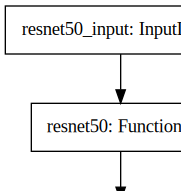

In [49]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [50]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


In [51]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/50
13/13 [==============================] - 229s 18s/step - loss: 33.2504 - accuracy: 0.5863 - val_loss: 351649.7500 - val_accuracy: 0.3939
Epoch 2/50
13/13 [==============================] - 226s 17s/step - loss: 4.5346 - accuracy: 0.5381 - val_loss: 1181.5760 - val_accuracy: 0.6061
Epoch 3/50
13/13 [==============================] - 232s 18s/step - loss: 1.3349 - accuracy: 0.6574 - val_loss: 1115.9797 - val_accuracy: 0.3939
Epoch 4/50
13/13 [==============================] - 240s 18s/step - loss: 1.9845 - accuracy: 0.6244 - val_loss: 135.3830 - val_accuracy: 0.6061
Epoch 5/50
13/13 [==============================] - 246s 19s/step - loss: 1.3303 - accuracy: 0.6548 - val_loss: 121.5941 - val_accuracy: 0.6061
Epoch 6/50
13/13 [==============================] - 237s 18s/step - loss: 1.1596 - accuracy: 0.6523 - val_loss: 1403.5610 - val_accuracy: 0.4242
Epoch 7/50
13/13 [==============================] - 236s 18s/step - loss: 0.7930 - accuracy: 0.6980 - val_loss: 1.7467 - val_accu

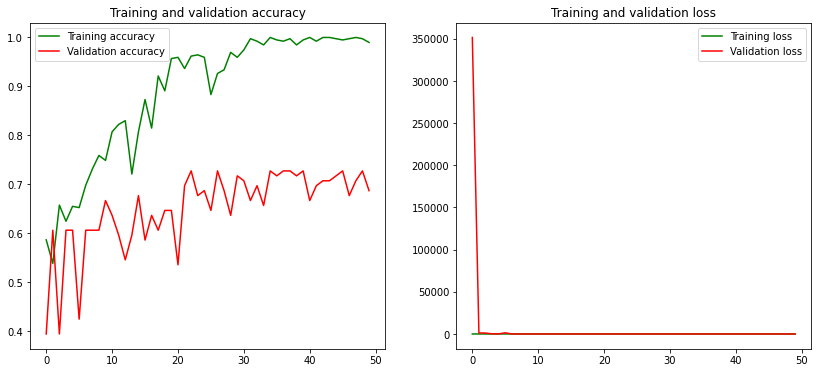

In [52]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

In [53]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])



Validation loss: 1.3988083600997925
Validation accuracy: 0.6868686676025391


In [54]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [55]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]


In [56]:
target_names = ["hypertension", "Normal"]
print(classification_report(y_true, predicted_classes, target_names=target_names))


              precision    recall  f1-score   support

hypertension       0.83      0.26      0.39        39
      Normal       0.67      0.97      0.79        60

    accuracy                           0.69        99
   macro avg       0.75      0.61      0.59        99
weighted avg       0.73      0.69      0.63        99

